# exploring data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2       # type: ignore
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from time import time

In [2]:
train_path = '/home/theodoros/dataset/GTSRB/Final_Training/Images'
test_path = '/home/theodoros/dataset/GTSRB/Final_Test/Images'

In [3]:
class GTSRBDataset(Dataset):
    def __init__(self, root_dir, load_type='Train', resize_size=(64, 64), transform=None, use_features=True):
        self.root_dir = root_dir
        self.load_type = load_type
        self.resize_size = resize_size
        self.transform = transform
        self.use_features = use_features
        self.data = []
        self._load_data()

    def _load_data(self):
        if self.load_type == "Train":
            class_dirs = sorted(os.listdir(self.root_dir))
            for class_id in class_dirs:
                class_dir = os.path.join(self.root_dir, class_id)
                class_label = int(class_id)
                annotation_file = os.path.join(class_dir, f'GT-{class_id}.csv')
                annotations = pd.read_csv(annotation_file, sep=';')

                for _, row in annotations.iterrows():
                    self.data.append({
                        'img_path': os.path.join(class_dir, row['Filename']),
                        'label': class_label,
                        'bbox': {
                            'x1': row['Roi.X1'], 'y1': row['Roi.Y1'],
                            'x2': row['Roi.X2'], 'y2': row['Roi.Y2'],
                            'original_width': row['Width'], 'original_height': row['Height']
                        }
                    })
        elif self.load_type == "Test":
            annotation_file = "/home/theodoros/dataset/GT-final_test.csv"
            annotations = pd.read_csv(annotation_file, sep=';')

            for _, row in annotations.iterrows():
                self.data.append({
                    'img_path': os.path.join(self.root_dir, row['Filename']),
                    'label': int(row['ClassId']),
                    'bbox': {
                        'x1': row['Roi.X1'], 'y1': row['Roi.Y1'],
                        'x2': row['Roi.X2'], 'y2': row['Roi.Y2'],
                        'original_width': row['Width'], 'original_height': row['Height']
                    }
                })

    def _process_image(self, img_path):
        img = cv2.imread(img_path)
        img_resize = cv2.resize(img, self.resize_size)
        img_norm = img_resize / 255.0
        gray = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)

        if self.use_features:
            hog_desc, hog_image = hog(
                gray,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                block_norm='L2-Hys',
                visualize=True,
                feature_vector=True
            )

            sift = cv2.SIFT_create()
            keypoints, descriptors = sift.detectAndCompute(gray, None)

            return img_norm, keypoints, descriptors, hog_desc, hog_image
        else:
            return img_norm, None, None, None, None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img_path = item['img_path']
        label = item['label']
        bbox = item['bbox']

        img_norm, keypoints, descriptors, hog_desc, hog_image = self._process_image(img_path)
        image_tensor = torch.tensor(img_norm, dtype=torch.float).permute(2, 0, 1)  # CHW format

        if self.transform:
            image_tensor = self.transform(image_tensor)

        # Normalize bbox coordinates to [0, 1] range based on original image size
        x_scale = self.resize_size[0] / bbox['original_width']
        y_scale = self.resize_size[1] / bbox['original_height']

        x1 = bbox['x1'] * x_scale / self.resize_size[0]
        y1 = bbox['y1'] * y_scale / self.resize_size[1]
        x2 = bbox['x2'] * x_scale / self.resize_size[0]
        y2 = bbox['y2'] * y_scale / self.resize_size[1]

        normalized_bbox = torch.tensor([x1, y1, x2, y2], dtype=torch.float32)

        sample = {
            'image': image_tensor,
            'label': torch.tensor(label, dtype=torch.long),
            'bbox': normalized_bbox
        }

        if self.use_features:
            if descriptors is None:
                descriptors = np.zeros((1, 128), dtype=np.float32)
            sample.update({
                'sift_features': descriptors,
                'hog_features': torch.tensor(hog_desc, dtype=torch.float),
                'hog_image': torch.tensor(hog_image, dtype=torch.float)
            })

        return sample

In [4]:
class SimpleResCNN(nn.Module):
    def __init__(self, num_classes=43):  ## Our dataset (GTSRB) has 43 classes
        super(SimpleResCNN, self).__init__()
        
        ## (first convvv)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)  ## 64 -> 32
        )
        
        ## (second convvv + skip conn)
        self.conv2_main = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        self.conv2_skip = nn.Conv2d(32, 64, kernel_size=1)

        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)  ## 32 -> 16

        ## (another final conv, like a combiner one)
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)  ## 16 -> 8
        )

        ## Classifier (final step)
        self.gap = nn.AdaptiveAvgPool2d(1)  ## 8x8 -> 1x1
        self.fc_class = nn.Linear(128, num_classes)
        self.fc_bbox = nn.Linear(128, 4)

    def forward(self, x):
        ## step 1
        x = self.conv1(x)  ## (3, 64, 64) -> (32, 32, 32)

        ## step 2
        identity = self.conv2_skip(x)  ## (32, 32, 32) -> (64, 32, 32)
        out = self.conv2_main(x)
        x = self.relu2(out + identity)  ## Residual conn
        x = self.pool2(x)  ## -> (64, 16, 16)

        ## step 3
        x = self.conv3(x)  ## -> (128, 8, 8)
        
        ## step 4
        x = self.gap(x).view(x.size(0), -1)  ## -> (128,)
        class_logits = self.fc_class(x)
        bbox_preds = self.fc_bbox(x)
        
        return class_logits, bbox_preds

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = GTSRBDataset(root_dir=train_path, load_type='Train', use_features=False)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = GTSRBDataset(root_dir=test_path, load_type='Test', use_features=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

model = SimpleResCNN(num_classes=43).to(device)
criterion_class = nn.CrossEntropyLoss()
criterion_bbox = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

device

device(type='cuda')


Epoch [1/5]


Epoch 1 completed in 37.40s
Train Loss: 1.9721 | Train Acc: 45.53%
Val Loss  : 1.2914 | Val Acc  : 62.45%

Epoch [2/5]


Epoch 2 completed in 25.78s
Train Loss: 0.4506 | Train Acc: 91.07%
Val Loss  : 0.4488 | Val Acc  : 88.39%

Epoch [3/5]


Epoch 3 completed in 26.07s
Train Loss: 0.0951 | Train Acc: 99.12%
Val Loss  : 0.2097 | Val Acc  : 95.70%

Epoch [4/5]


Epoch 4 completed in 25.99s
Train Loss: 0.0380 | Train Acc: 99.75%
Val Loss  : 0.1817 | Val Acc  : 95.76%

Epoch [5/5]


Epoch 5 completed in 34.60s
Train Loss: 0.0204 | Train Acc: 99.90%
Val Loss  : 0.1341 | Val Acc  : 96.84%


In [ ]:
class_names = [
    "Speed limit (20km/h)",                  # 0
    "Speed limit (30km/h)",                  # 1
    "Speed limit (50km/h)",                  # 2
    "Speed limit (60km/h)",                  # 3
    "Speed limit (70km/h)",                  # 4
    "Speed limit (80km/h)",                  # 5
    "End of speed limit (80km/h)",           # 6
    "Speed limit (100km/h)",                 # 7
    "Speed limit (120km/h)",                 # 8
    "No passing",                            # 9
    "No passing for vehicles over 3.5 metric tons",  # 10
    "Right-of-way at the next intersection", # 11
    "Priority road",                         # 12
    "Yield",                                 # 13
    "Stop",                                  # 14
    "No vehicles",                           # 15
    "Vehicles over 3.5 metric tons prohibited",      # 16
    "No entry",                              # 17
    "General caution",                       # 18
    "Dangerous curve to the left",           # 19
    "Dangerous curve to the right",          # 20
    "Double curve",                          # 21
    "Bumpy road",                            # 22
    "Slippery road",                         # 23
    "Road narrows on the right",             # 24
    "Road work",                             # 25
    "Traffic signals",                       # 26
    "Pedestrians",                           # 27
    "Children crossing",                     # 28
    "Bicycles crossing",                     # 29
    "Beware of ice/snow",                    # 30
    "Wild animals crossing",                 # 31
    "End of all speed and passing limits",   # 32
    "Turn right ahead",          ﻿            # 33
    "Turn left ahead",                       # 34
    "Ahead only",                            # 35
    "Go straight or right",                  # 36
    "Go straight or left",                   # 37
    "Keep right",                            # 38
    "Keep left",                             # 39
    "Roundabout mandatory",                  # 40
    "End of no passing",                     # 41
    "End of no passing by vehicles over 3.5 metric tons"  # 42
]


In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import torch
from sklearn.cluster import KMeans

def segment_image_kmeans(image, n_clusters=10):
    h, w, c = image.shape
    flat_img = image.reshape(-1, 3)  ## for RGB
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
    labels = kmeans.fit_predict(flat_img)
    segmented_img = labels.reshape(h, w)
    return segmented_img

def visualize_predictions(model, test_dataset, device, num_samples=5):
    model.eval()
    indices = random.sample(range(len(test_dataset)), num_samples)

    plt.figure(figsize=(14, num_samples * 5))
    
    for i, idx in enumerate(indices):
        sample = test_dataset[idx]
        image_tensor = sample['image']
        true_label = sample['label']
        true_bbox = sample['bbox']

        image = image_tensor.unsqueeze(0).to(device)

        with torch.inference_mode():
            logits, pred_bbox = model(image)
            probs = F.softmax(logits, dim=1)
            pred_label = torch.argmax(probs, dim=1).item()
            confidence = probs[0, pred_label].item()
            pred_bbox = pred_bbox.squee/home/theodoros/dataset/GTSRB/Final_Test/Images/00000.ppmshape[:2]

        ## Segmenting the image using KMeans
        segmented_img = segment_image_kmeans(img)

        ## De-normalizing the true bboxes
        x1, y1, x2, y2 = true_bbox
        x1 *= img_width
        y1 *= img_height
        x2 *= img_width
        y2 *= img_height
        true_w = x2 - x1
        true_h = y2 - y1

        ## De-normalizing the predicted bboxes
        pred_bbox = pred_bbox.clone()
        x1_pred, y1_pred, x2_pred, y2_pred = pred_bbox
        x1_pred *= img_width
        y1_pred *= img_height
        x2_pred *= img_width
        y2_pred *= img_height
        pred_w = x2_pred - x1_pred
        pred_h = y2_pred - y1_pred

        ## Show Original Image + BBoxes
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(img)
        ax = plt.gca()

        ## true bboxes are drawn in green
        rect = plt.Rectangle((x1, y1), true_w, true_h, edgecolor='green', facecolor='none', linewidth=2, label='True')
        ax.add_patch(rect)

        ## predicted bboxes are drawn in red
        rect = plt.Rectangle((x1_pred, y1_pred), pred_w, pred_h, edgecolor='red', facecolor='none', linewidth=2, label='Pred')
        ax.add_patch(rect)

        plt.title(f"GT: {class_names[true_label]} | Pred: {class_names[pred_label]} ({confidence:.2f})")
        plt.axis('off')

        ## Show Segmentation only
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(segmented_img, cmap='nipy_spectral')
        plt.title(f"KMeans Segmentation (K = 4)")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.4)
    plt.tight_layout()
    plt.show()
    

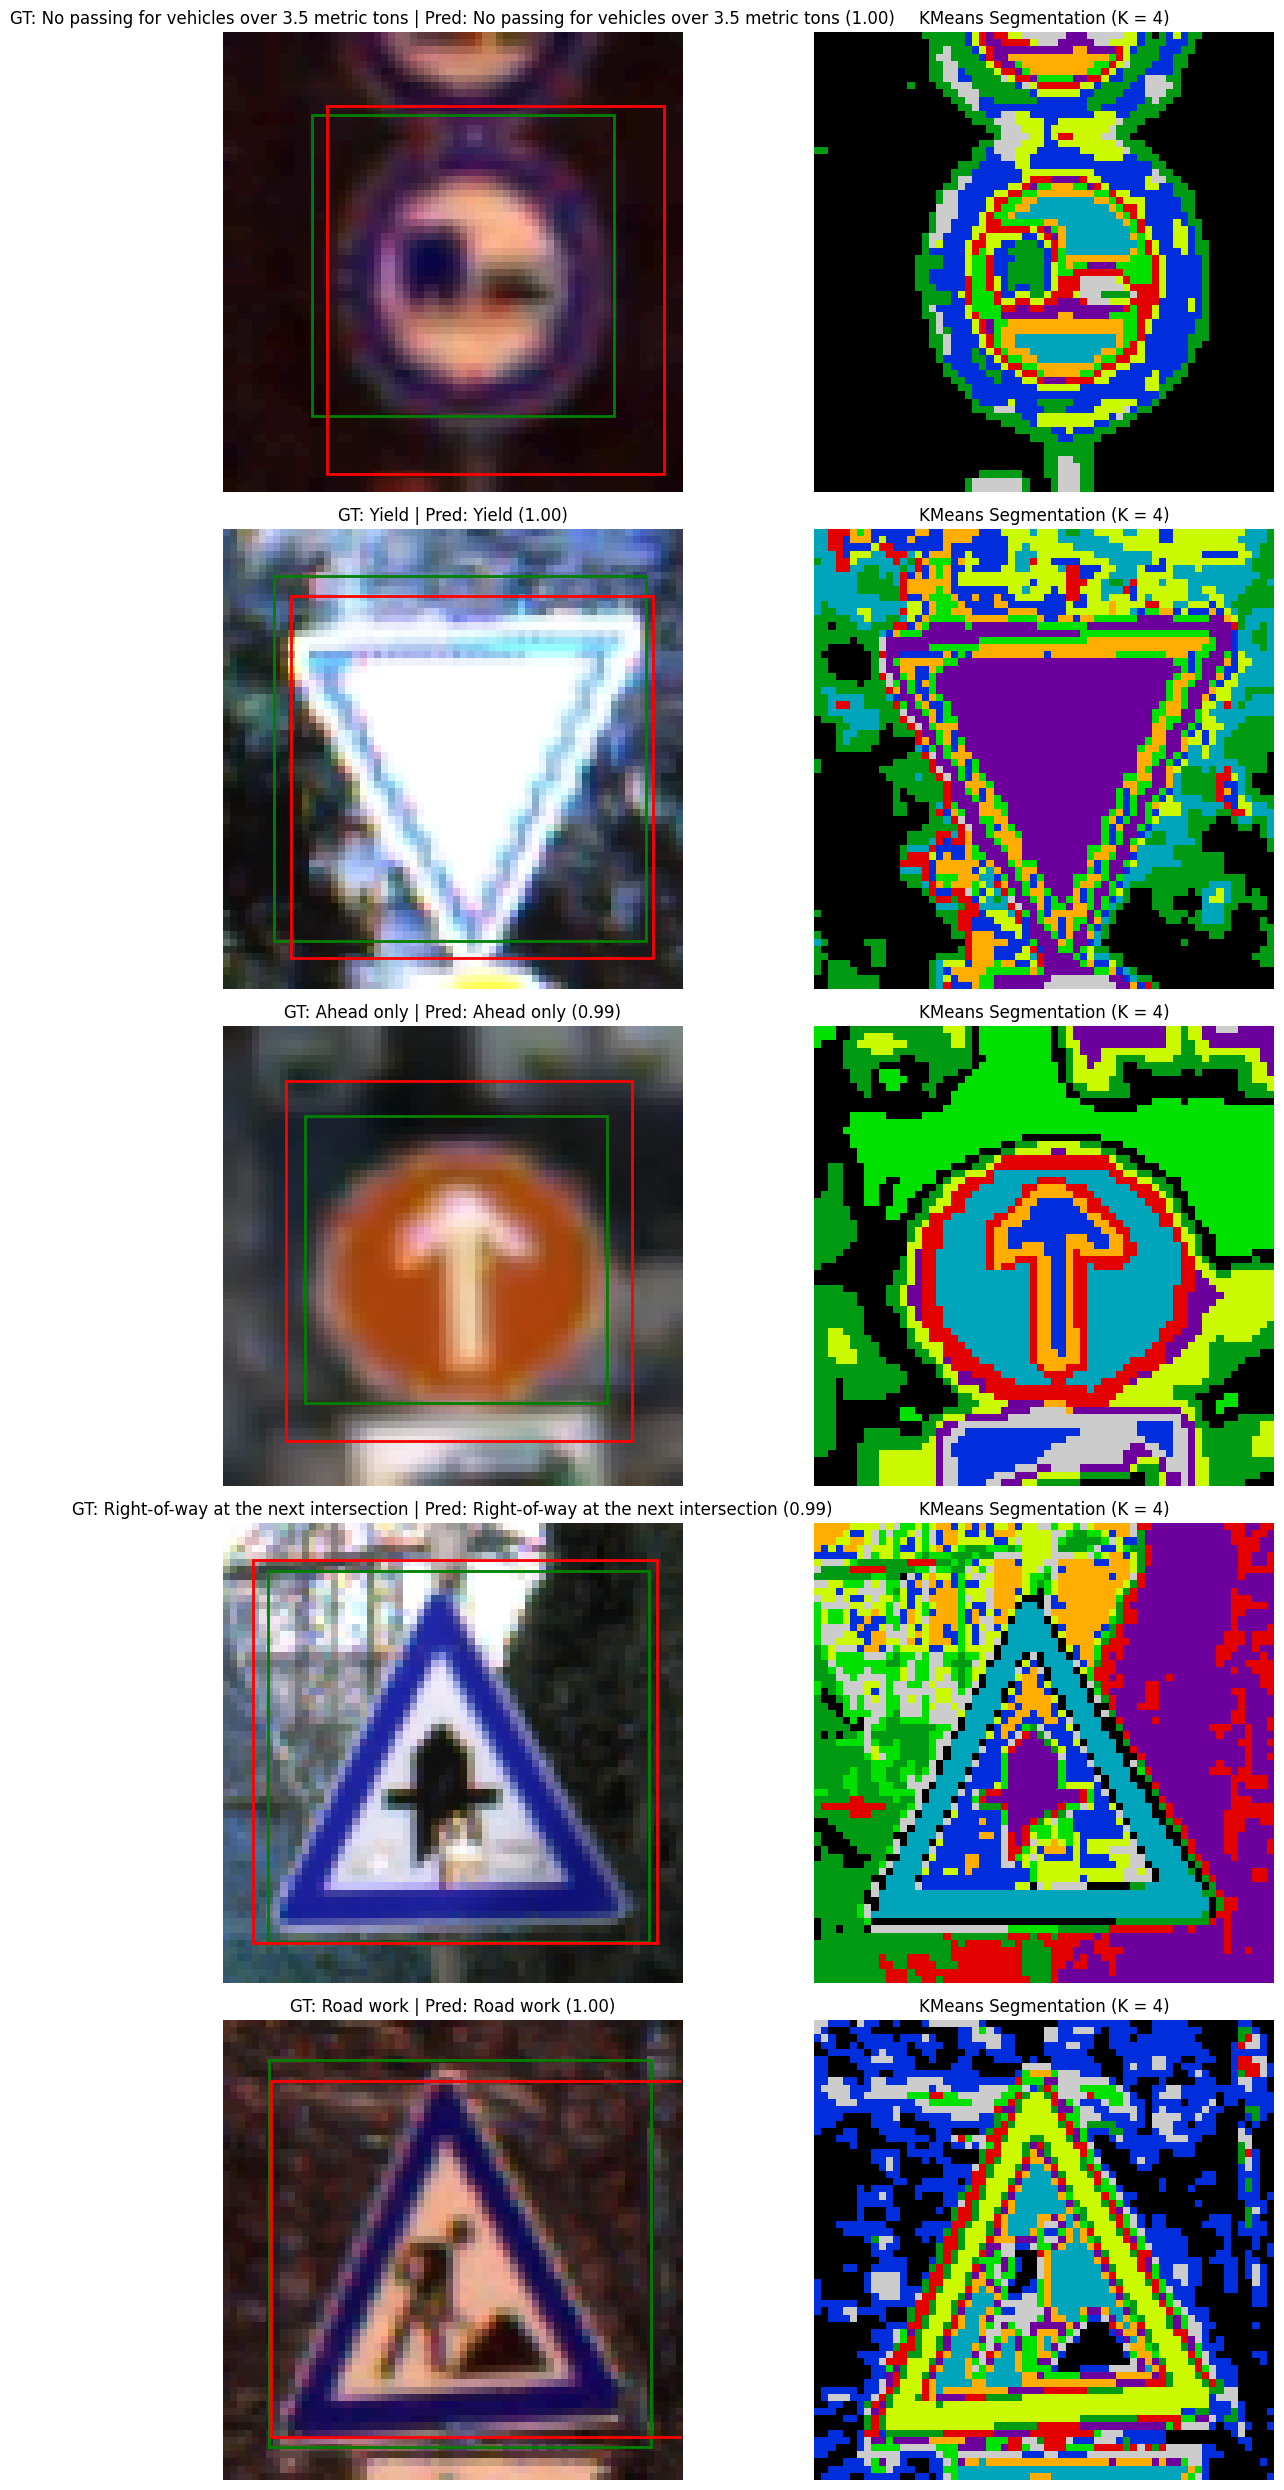

In [13]:
visualize_predictions(model, test_dataset, device)

In [11]:
torch.save(model.state_dict(), "/home/theodoros/projects/Traffic_signs/model_weights.pth") # save to use for gui 